In [1]:
# ---LIBRARIES---
import os

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.signal import find_peaks

#### Random bit generator:


In [19]:
# Set the number of random numbers to generate
n = 50

# Generate n random numbers, either 0 or 1, using the randi() function
rand_nums = np.random.randint(2, size=n)

# Display the random numbers
print(rand_nums)


[1 1 0 0 0 1 0 1 1 0 1 1 1 0 0 0 0 0 0 0 1 1 1 0 0 1 0 1 1 1 0 1 1 1 1 0 0
 0 0 1 1 0 0 1 0 1 1 1 1 0]


### PART I: PERPENDICULAR ANGLES ,10 ,25, 50 BIT.


##### Density matrix data simulation, state analysis and plotting functions:


In [17]:
def get_state(name="psi_1"):
    """Returns theoretical state for simulation."""
    if name == "psi_1":  # (|HH> + |VV>) / sqrt(2)
        psi = np.array([1, 0, 0, 1]) / np.sqrt(2)
        rho = np.outer(psi, psi)
    elif name == "psi_2":  # (|HV> + |VH>) / sqrt(2)
        psi = np.array([0, 1, 1, 0]) / np.sqrt(2)
        rho = np.outer(psi, psi)
    elif name == "mixed":
        rho = np.diag([0.5, 0, 0, 0.5])
    else:
        raise ValueError("Unknown state")
    return rho


def simulate_measurement(rho, alpha_deg, beta_deg, N_pulses=1000):
    """Simulates photon counts for specific polarizer angles."""
    a = np.radians(alpha_deg)
    b = np.radians(beta_deg)

    # Vectors
    alice_vec = np.array([np.cos(a), np.sin(a)])
    bob_vec = np.array([np.cos(b), np.sin(b)])

    # Operator & Probability
    meas_op = np.kron(np.outer(alice_vec, alice_vec), np.outer(bob_vec, bob_vec))
    prob = np.trace(rho @ meas_op)
    prob = np.clip(np.real(prob), 0, 1)

    return int(np.round(prob * N_pulses))


def reconstruct_density_matrix(N_HH, N_HV, N_VH, N_VV):
    """
    Reconstructs the density matrix using population data and
    estimates coherence assuming a pure state.
    """
    total_HV = N_VV + N_HH + N_VH + N_HV
    if total_HV == 0:
        total_HV = 1  # Avoid division by zero

    # Calculate Diagonal Elements (Populations)
    # Matrix indices: 0=|HH>, 1=|HV>, 2=|VH>, 3=|VV>
    rho_00 = N_HH / total_HV  # |HH><HH|
    rho_11 = N_HV / total_HV  # |HV><HV|
    rho_22 = N_VH / total_HV  # |VH><VH|
    rho_33 = N_VV / total_HV  # |VV><VV|

    # Calculate Off-Diagonal Elements (Coherence)
    coherence = 0.0

    # ESTIMATION METHOD
    # Check which state we have: Correlated (|psi1>) or Anti-Correlated (|psi2>)
    if (rho_00 + rho_33) > (rho_11 + rho_22):
        # Case: |psi1> ~ (|HH> + |VV>)
        print("Detected Correlated State")
        # FIX: Remove 0.5 factor and the noise term
        coherence = np.sqrt(rho_00 * rho_33)
        state_type = "Correlated"
    else:
        # Case: |psi2> ~ (|HV> + |VH>)
        print("Detected Anti-Correlated State")
        # FIX: Remove 0.5 factor and the noise term
        coherence = np.sqrt(rho_11 * rho_22)
        state_type = "Anti-Correlated"

    # Build the 4x4 Density Matrix
    rho_rec = np.zeros((4, 4))

    # Fill Diagonals
    rho_rec[0, 0] = rho_00
    rho_rec[1, 1] = rho_11
    rho_rec[2, 2] = rho_22
    rho_rec[3, 3] = rho_33

    # Fill Off-Diagonals (Symmetric Real Matrix)
    if state_type == "Correlated":
        # Coherence is between HH (0) and VV (3)
        rho_rec[0, 3] = coherence
        rho_rec[3, 0] = coherence
    else:
        # Coherence is between HV (1) and VH (2)
        rho_rec[1, 2] = coherence
        rho_rec[2, 1] = coherence

    return rho_rec


# --- PLOTTING FUNCTION ---


def plot_3d_matrix(rho, title="Reconstructed Density Matrix"):
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection="3d")

    # Grid setup
    x_labels = ["HH", "HV", "VH", "VV"]
    y_labels = ["HH", "HV", "VH", "VV"]
    _x = np.arange(4)
    _y = np.arange(4)
    _xx, _yy = np.meshgrid(_x, _y)
    x, y = _xx.ravel(), _yy.ravel()

    # Bar heights
    top = np.real(rho).ravel()
    bottom = np.zeros_like(top)
    width = depth = 0.5

    ax.bar3d(x, y, bottom, width, depth, top, shade=True)

    ax.set_xticks(_x + 0.5)
    ax.set_xticklabels(x_labels, fontweight="bold")
    ax.set_yticks(_y + 0.5)
    ax.set_yticklabels(y_labels, fontweight="bold")
    ax.set_zlim(0, 0.6)
    ax.set_title(title)
    plt.savefig(title)
    plt.show()


##### Density matrix data simulation execution and plot:


--- Generating Simulated Data ---
Counts: HH=0, HV=50, VH=50, VV=0

--- 2. Reconstructing Matrix ---
Detected Anti-Correlated State

Reconstructed Matrix (Real Part):
[[0.  0.  0.  0. ]
 [0.  0.5 0.5 0. ]
 [0.  0.5 0.5 0. ]
 [0.  0.  0.  0. ]]

--- 3. Plotting ---


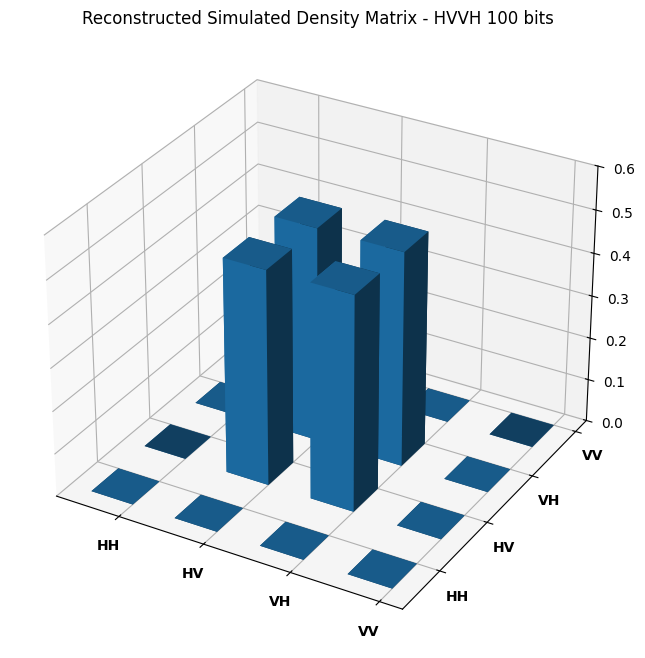

In [18]:
# --- Generate Simulation Data ---
print("--- Generating Simulated Data ---")
target_state = "psi_2"  # either psi_1 or psi_2
rho_theoretical = get_state(target_state)
N_sim = 100

N_HH = simulate_measurement(rho_theoretical, 0, 0, N_sim)
N_HV = simulate_measurement(rho_theoretical, 0, 90, N_sim)
N_VH = simulate_measurement(rho_theoretical, 90, 0, N_sim)
N_VV = simulate_measurement(rho_theoretical, 90, 90, N_sim)

print(f"Counts: HH={N_HH}, HV={N_HV}, VH={N_VH}, VV={N_VV}")

print("\n--- 2. Reconstructing Matrix ---")
rho_final = reconstruct_density_matrix(N_HH, N_HV, N_VH, N_VV)

print("\nReconstructed Matrix (Real Part):")
print(np.round(np.real(rho_final), 3))

# Plot
print("\n--- 3. Plotting ---")
plot_3d_matrix(
    rho_final, title=f"Reconstructed Simulated Density Matrix - HVVH {N_sim} bits"
)

### Video analysis function:


In [ ]:
def image_analysis(ROI_COUNT, labels, RESIZE_FACTOR, ROI_exe=True):
    for i in range(ROI_COUNT):
        if ROI_exe:  # if ROI wasnt given
            print(f"--- Select {labels[i]} ---")
            window_name = f"Select {labels[i]} (Draw & Press SPACE)"

            # Show selection window
            r_small = cv2.selectROI(
                window_name, small_frame, fromCenter=False, showCrosshair=True
            )
            cv2.destroyWindow(window_name)

            # Handle empty selection
            if r_small == (0, 0, 0, 0):
                print(
                    f"Warning: ROI {i + 1} was empty! Setting to 1x1 pixel to avoid crash."
                )
                r_small = (0, 0, 1, 1)  # Fallback

            # Scale coordinates back to original video size
            x = int(r_small[0] * scale_up)
            y = int(r_small[1] * scale_up)
            w = int(r_small[2] * scale_up)
            h = int(r_small[3] * scale_up)

            roi_coords.append((x, y, w, h))

            # Draw the selected box on 'small_frame' permanently
            cv2.rectangle(
                small_frame,
                (r_small[0], r_small[1]),
                (r_small[0] + r_small[2], r_small[1] + r_small[3]),
                roi_colors[i],
                2,
            )

            print("Selections complete. Processing video...")

    # Reset video
    cap.set(cv2.CAP_PROP_POS_FRAMES, 0)

    # Create a list of 4 empty lists to store data: [[], [], [], []]
    results = [[] for _ in range(ROI_COUNT)]

    # MAIN PROCESSING LOOP
    while True:
        ret, frame = cap.read()
        if not ret:
            break

        for i in range(ROI_COUNT):
            x, y, w, h = roi_coords[i]

            # Extract the ROI
            roi = frame[y : y + h, x : x + w]
            # FILTERING FOR ONLY RED COLOR:
            roi_hsv = cv2.cvtColor(roi, cv2.COLOR_BGR2HSV)
            lower_red_1 = np.array([0, 100, 100])  # Hue, Saturation, Value
            upper_red_1 = np.array([10, 255, 255])

            # Upper range (170-180)
            lower_red_2 = np.array([170, 100, 100])
            upper_red_2 = np.array([180, 255, 255])

            # Create the masks using cv2.inRange()
            mask1 = cv2.inRange(roi_hsv, lower_red_1, upper_red_1)
            mask2 = cv2.inRange(roi_hsv, lower_red_2, upper_red_2)

            # Combine the masks
            # Use bitwise OR operation to combine the two masks
            red_mask = mask1 | mask2
            result = red_mask  # filtered image array
            results[i].append(np.sum(result))

        # --- VISUALIZATION ---
        display_frame = cv2.resize(frame, (new_width, new_height))

        # Draw all 4 rectangles
        for i in range(ROI_COUNT):
            x, y, w, h = roi_coords[i]
            # Scale down for display
            sx, sy, sw, sh = (
                int(x * RESIZE_FACTOR),
                int(y * RESIZE_FACTOR),
                int(w * RESIZE_FACTOR),
                int(h * RESIZE_FACTOR),
            )
            cv2.rectangle(display_frame, (sx, sy), (sx + sw, sy + sh), roi_colors[i])

    cap.release()
    cv2.destroyAllWindows()
    return results


##### Density matrix data processing and plot:


In [9]:
# ---importing bit lists---
df_bit_10 = pd.read_excel(
    "part one bit.xlsx", sheet_name="10 bit random list", usecols="A", header=None
)
df_bit_25 = pd.read_excel(
    "part one bit.xlsx", sheet_name="25 bit random list", usecols="A", header=None
)
df_bit_50 = pd.read_excel(
    "part one bit.xlsx", sheet_name="50 bit random list", usecols="A", header=None
)
bit_list_10 = df_bit_10[0].tolist()
bit_list_25 = df_bit_25[0].tolist()
bit_list_50 = df_bit_50[0].tolist()

In [32]:
# --- SETTINGS ---
video_path = r"ZIV AND TOMER PART 1\25 bit measurments.mp4"
RESIZE_FACTOR = 0.5  # Resize window to 50% for selection
ROI_COUNT = 4  # How many areas you want to select

if not os.path.exists(video_path):
    print("Error: File not found.")
    exit()

cap = cv2.VideoCapture(video_path)
ret, first_frame = cap.read()
if not ret:
    print("Could not read the video.")
    exit()

if "10" in video_path:
    bit_list = bit_list_10

elif "25" in video_path:
    bit_list = bit_list_25

elif "50" in video_path:
    bit_list = bit_list_50

H_num = 0
V_num = 0
for i in bit_list:
    if i == 0:
        H_num += 1
    elif i == 1:
        V_num += 1
    else:
        print("BIT LIST CONTAINS VALUES THAT ARE NOT 1 OR 0")

# --- RESIZE FOR SELECTION ---

height, width = first_frame.shape[:2]
new_width = int(width * RESIZE_FACTOR)
new_height = int(height * RESIZE_FACTOR)
small_frame = cv2.resize(first_frame, (new_width, new_height))
scale_up = 1 / RESIZE_FACTOR

# List to store the coordinates of the 4 ROIs
roi_coords = []
roi_colors = [
    (255, 0, 0),
    (0, 255, 0),
    (0, 0, 255),
    (0, 255, 255),
]  # Blue, Green, Red, Yellow

labels = ["Alice V", "Alice H", "Bob V", "Bob H"]

print(f"Please select {ROI_COUNT} different areas.")

results = image_analysis(ROI_COUNT, labels, 0.5)
print(roi_coords)

Please select 4 different areas.
--- Select Alice V ---
Selections complete. Processing video...
--- Select Alice H ---
Selections complete. Processing video...
--- Select Bob V ---
Selections complete. Processing video...
--- Select Bob H ---
Selections complete. Processing video...
[(318, 94, 226, 174), (324, 442, 230, 182), (744, 84, 174, 178), (700, 446, 228, 182)]


ROI        | Count | Threshold 
------------------------------
Alice V    | 11    | 50000.0   
Alice H    | 13    | 60000.0   
Bob V      | 10    | 150000.0  
Bob H      | 13    | 100000.0  


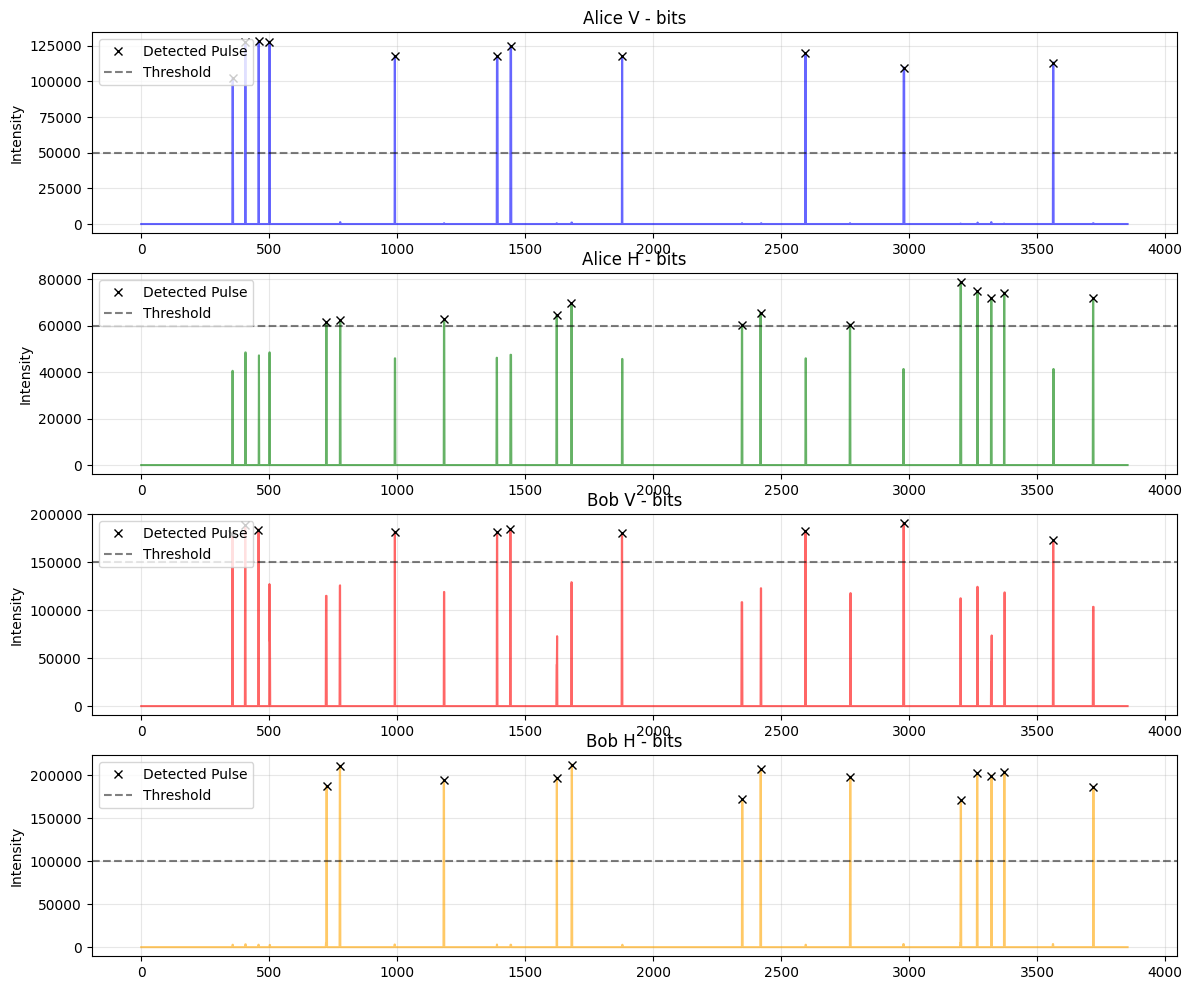

In [36]:
# --- CONFIGURATION ---

# distance=10 means peaks must be at least 10 frames apart to be distinct.
PEAK_DISTANCE = 10


# Thresholds (Order: Alice V, Alice H, Bob V, Bob H)
# Ensure these match the order of your ROI selection labels
thresholds = [50000.0, 60000.0, 150000.0, 100000.0]

# --- switching bob V and H ---
half_wave = True

if half_wave == False:
    results[2], results[3] = results[3], results[2]
    thresholds[2], thresholds[3] = thresholds[3], thresholds[2]

colors = ["b", "g", "r", "orange"]
roi_labels = ["Alice V", "Alice H", "Bob V", "Bob H"]

# Store the frame numbers where peaks occurred for coincidence logic
peak_indices = []

print(f"{'ROI':<10} | {'Count':<5} | {'Threshold':<10}")
print("-" * 30)

plt.figure(figsize=(14, 12))

for i in range(ROI_COUNT):
    signal_data = np.array(results[i])
    #  filtering peaks to set distance between one another and threshhold height
    peaks_x, properties = find_peaks(
        signal_data, height=thresholds[i], distance=PEAK_DISTANCE
    )

    peak_indices.append(peaks_x)  # Saving frame number

    print(f"{roi_labels[i]:<10} | {len(peaks_x):<5} | {thresholds[i]:<10}")

    # --- PLOTTING ---
    plt.subplot(ROI_COUNT, 1, i + 1)
    plt.plot(signal_data, color=colors[i], alpha=0.6)
    plt.plot(peaks_x, signal_data[peaks_x], "x", color="black", label="Detected Pulse")
    plt.axhline(thresholds[i], color="k", linestyle="--", alpha=0.5, label="Threshold")
    plt.ylabel("Intensity")
    plt.title(f"{roi_labels[i]} - bits")
    plt.legend(loc="upper left")
    plt.grid(True, alpha=0.3)


def plot():
    plt.xlabel("Frame Number")
    plt.tight_layout()
    plt.savefig("measurments and peaks -  bits")
    plt.show()



--- COINCIDENCE RESULTS FOR TOMOGRAPHY ---
N_VV (Alice V & Bob V): 10
N_HH (Alice H & Bob H): 13
N_VH (Alice V & Bob H): 0
N_HV (Alice H & Bob V): 0
Detected Correlated State


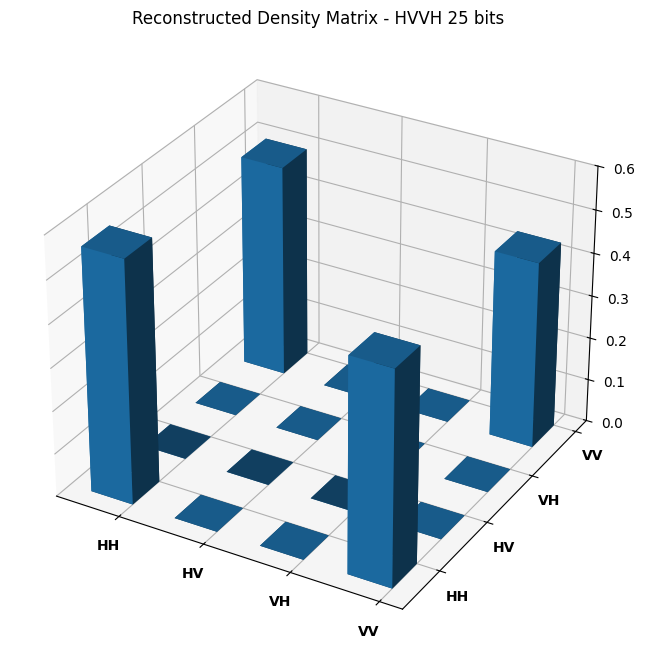

In [37]:
def count_coincidences(peaks_A, peaks_B, tolerance=10):
    coincidence_count = 0
    # For every peak in A, is there a peak in B nearby?
    for pA in peaks_A:
        # Check if any peak in B is close to pA
        if np.any(np.abs(peaks_B - pA) <= tolerance):
            coincidence_count += 1
    return coincidence_count


# Calculate Coincidences based on ROI order:
# Alice V
# Alice H
# Bob V
# Bob H

N_VV = count_coincidences(peak_indices[0], peak_indices[2])  # Alice V and Bob V
N_HH = count_coincidences(peak_indices[1], peak_indices[3])  # Alice H and Bob H
N_VH = count_coincidences(peak_indices[0], peak_indices[3])  # Alice V and Bob H
N_HV = count_coincidences(peak_indices[1], peak_indices[2])  # Alice H and Bob V

print("\n--- COINCIDENCE RESULTS FOR TOMOGRAPHY ---")
print(f"N_VV (Alice V & Bob V): {N_VV}")
print(f"N_HH (Alice H & Bob H): {N_HH}")
print(f"N_VH (Alice V & Bob H): {N_VH}")
print(f"N_HV (Alice H & Bob V): {N_HV}")

# Total coincidences in H/V basis
rho = reconstruct_density_matrix(N_HH, N_HV, N_VH, N_VV)

# plot
if half_wave == True:
    title = f"Reconstructed Density Matrix - HVVH {H_num + V_num} bits"
else:
    title = f"Reconstructed Density Matrix - HHVV {H_num + V_num} bits"
plot_3d_matrix(rho, title=title)


### PART II: 20 BIT DIFFERENT ANGLES.


<>:115: SyntaxWarning: invalid escape sequence '\c'
<>:119: SyntaxWarning: invalid escape sequence '\c'
<>:115: SyntaxWarning: invalid escape sequence '\c'
<>:119: SyntaxWarning: invalid escape sequence '\c'
C:\Users\zivsh\AppData\Local\Temp\ipykernel_4276\893322675.py:115: SyntaxWarning: invalid escape sequence '\c'
  ax.set_title(f"$\\beta = {beta}^\circ$", fontsize=12)
C:\Users\zivsh\AppData\Local\Temp\ipykernel_4276\893322675.py:119: SyntaxWarning: invalid escape sequence '\c'
  f"$\\alpha = {alpha}^\circ$", fontsize=12, rotation=270, labelpad=15


Processed 1/16: N(-45,-22.5) = 4
Processed 2/16: N(-45,22.5) = 0
Processed 3/16: N(-45,67.5) = 8
Processed 4/16: N(-45,112.5) = 9
Processed 5/16: N(0,-22.5) = 7
Processed 6/16: N(0,22.5) = 11
Processed 7/16: N(0,67.5) = 3
Processed 8/16: N(0,112.5) = 0
Processed 9/16: N(45,-22.5) = 3
Processed 10/16: N(45,22.5) = 12
Processed 11/16: N(45,67.5) = 7
Processed 12/16: N(45,112.5) = 0
Processed 13/16: N(90,-22.5) = 0
Processed 14/16: N(90,22.5) = 0
Processed 15/16: N(90,67.5) = 9
Processed 16/16: N(90,112.5) = 6


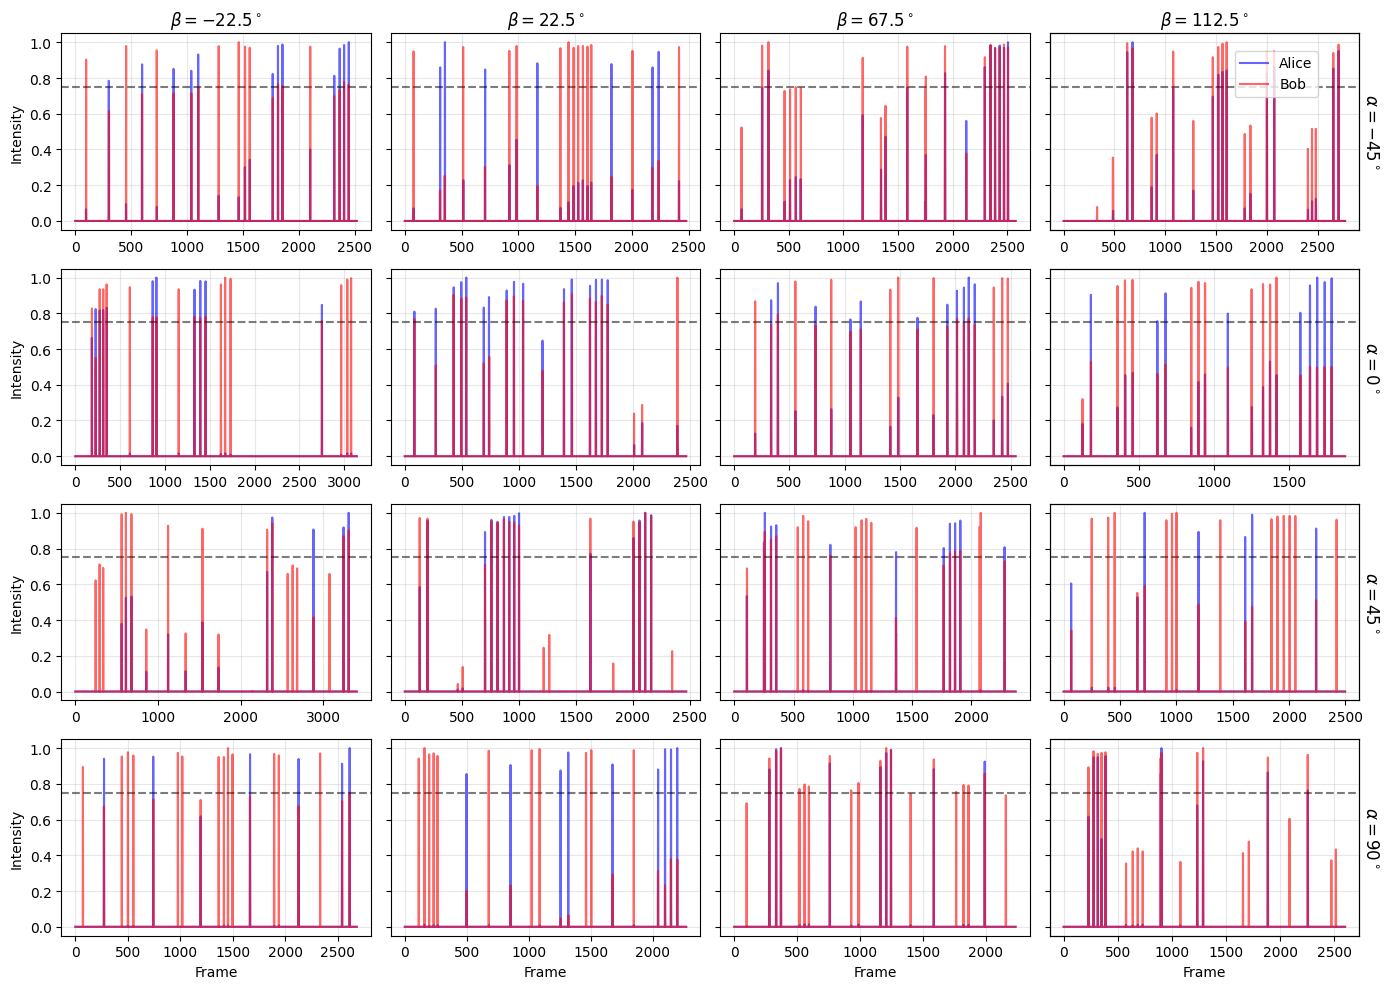


--- Final Counts ---
N(-45,-22.5): 4
N(-45,22.5): 0
N(-45,67.5): 8
N(-45,112.5): 9
N(0,-22.5): 7
N(0,22.5): 11
N(0,67.5): 3
N(0,112.5): 0
N(45,-22.5): 3
N(45,22.5): 12
N(45,67.5): 7
N(45,112.5): 0
N(90,-22.5): 0
N(90,22.5): 0
N(90,67.5): 9
N(90,112.5): 6


In [22]:
# --- CONFIGURATION ---
alpha_angles = [-45, 0, 45, 90]
beta_angles = [-22.5, 22.5, 67.5, 112.5]

PEAK_DISTANCE = 20
threshhold = 0.75
COINCIDENCE_WINDOW = 1
RESIZE_FACTOR = 0.8  # Resize window for ROI selection

labels = ["Alice", "Bob"]
ROI_COUNT = 2
scale_up = 1 / RESIZE_FACTOR

# List of ROIs
roi_coords = [(80, 218, 380, 340), (822, 280, 314, 282)]
roi_colors = [(255, 0, 0), (0, 0, 255)]
colors = ["b", "r"]


def calculate_coincidences(peaks_a, peaks_b, window=1):
    """
    Counts how many peaks in A have a PARTNER in B within 'window' frames.
    """
    if len(peaks_a) == 0 or len(peaks_b) == 0:
        return 0

    count = 0
    used_b = set()

    for pa in peaks_a:
        for pb in peaks_b:
            if pb in used_b:
                continue  # Skip if this Bob peak was already paired

            if abs(pa - pb) <= window:
                count += 1
                used_b.add(pb)  # preventing double count
                break

    return count


# --- SETUP PLOT ---
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(14, 10), sharex=False, sharey=True)
counts_dict = {}

# --- MAIN LOOP ---
t = 0
for row_idx, alpha in enumerate(alpha_angles):
    for col_idx, beta in enumerate(beta_angles):
        ax = axes[row_idx, col_idx]

        # 1. Load Video
        video_path = os.path.join(f"ALPHA {alpha}", f"{beta}.mp4")

        cap = cv2.VideoCapture(video_path)

        if not cap.isOpened():
            print(f"Warning: Could not open {video_path}")
            results = [[], []]
        else:
            ret, first_frame = cap.read()
            if ret:
                height, width = first_frame.shape[:2]
                new_width = int(width * RESIZE_FACTOR)
                new_height = int(height * RESIZE_FACTOR)
                scale_up = 1 / RESIZE_FACTOR
                # Reset to frame 0 for analysis
                cap.set(cv2.CAP_PROP_POS_FRAMES, 0)

            results = image_analysis(ROI_COUNT, labels, 0.8, ROI_exe=False)
            cap.release()

        # Process Signals
        found_peaks_list = [[], []]

        for i in range(ROI_COUNT):
            signal_data = np.array(results[i])
            if len(signal_data) == 0:
                continue

            norm_signal_data = (signal_data - np.min(signal_data)) / (
                np.max(signal_data) - np.min(signal_data)
            )  # data normalisation
            # Find Peaks using the specific threshold for this camera
            peaks_x, _ = find_peaks(
                norm_signal_data, height=threshhold, distance=PEAK_DISTANCE
            )

            found_peaks_list[i] = peaks_x

            # Plot
            ax.plot(
                norm_signal_data,
                color=colors[i],
                alpha=0.6,
                label=f"{labels[i]}" if (row_idx == 0 and col_idx == 0) else "",
            )
            ax.axhline(threshhold, color="k", linestyle="--", alpha=0.3)

        # calculating counts
        N_val = calculate_coincidences(
            found_peaks_list[0], found_peaks_list[1], window=COINCIDENCE_WINDOW
        )

        # Storing result
        N_name = f"N({alpha},{beta})"
        counts_dict[N_name] = N_val

        # Ploting:
        ax.grid(True, alpha=0.3)

        # Labels
        if row_idx == 0:
            ax.set_title(f"$\\beta = {beta}^\circ$", fontsize=12)
        if col_idx == 3:
            ax2 = ax.twinx()
            ax2.set_ylabel(
                f"$\\alpha = {alpha}^\circ$", fontsize=12, rotation=270, labelpad=15
            )
            ax2.set_yticks([])
        if row_idx == 3:
            ax.set_xlabel("Frame")
        if col_idx == 0:
            ax.set_ylabel("Intensity")

        t += 1
        print(f"Processed {t}/16: {N_name} = {N_val}")

# ---- Plot ----
fig.legend(loc="upper right", bbox_to_anchor=(0.95, 0.95))
plt.tight_layout()
plt.savefig("Bell_Inequality_Grid.png", dpi=300)
plt.show()

print("\n--- Final Counts ---")
for key, value in counts_dict.items():
    print(f"{key}: {value}")

### Calculating Bell Test


In [ ]:
def get_N(a, b):
    """fixing addition in angles to match format and returning corrosponding counts"""
    a = a % 360
    b = b % 360

    if a == 135:
        a = -45
    if b == 157.5:
        b = -22.5
    key = f"N({a},{b})"
    return counts_dict[key]


def E(alpha, beta):
    """calculating E"""
    N_ab = get_N(alpha, beta)
    N_ap_bp = get_N(alpha + 90, beta + 90)
    N_a_bp = get_N(alpha, beta + 90)
    N_ap_b = get_N(alpha + 90, beta)

    denominator = N_ab + N_ap_bp + N_a_bp + N_ap_b

    if denominator == 0:
        return 0
    return (N_ab + N_ap_bp - N_a_bp - N_ap_b) / denominator


alpha = 0
alpha_tag = 45
beta = 22.5
beta_tag = 67.5

# --- calculating bell test ---
S = E(alpha, beta) - E(alpha, beta_tag) + E(alpha_tag, beta) + E(alpha_tag, beta_tag)
print(f"S = {S}")

S = 2.6842105263157894
